# Information Retrieval: From Vector Space to Learning to Rank

**Topics Covered:**
1. Vector Space Model & TF-IDF
2. Cosine Similarity
3. Rocchio Algorithm (Relevance Feedback)
4. k-Nearest Neighbors
5. Evaluation Metrics (Precision, Recall, MAP, nDCG)
6. Learning to Rank: Pointwise, Pairwise, Listwise
7. Key Algorithms: RankSVM, RankNet, LambdaMART

---

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Expanded document collection for more interesting visualizations
documents = [
    "Machine learning algorithms can learn from data",
    "Deep learning uses neural networks with many layers",
    "Natural language processing helps computers understand text",
    "Computer vision enables machines to interpret images",
    "Supervised learning requires labeled training data",
    "Unsupervised learning finds patterns without labels",
    "Reinforcement learning learns through trial and error",
    "Neural networks are inspired by biological neurons",
    "Gradient descent optimizes machine learning models",
    "Convolutional networks excel at image recognition",
    "Recurrent networks process sequential data effectively",
    "Transfer learning reuses pretrained models",
    "Ensemble methods combine multiple models",
    "Decision trees make predictions using rules",
    "Support vector machines find optimal boundaries"
]

query = "neural networks deep learning"

print(f"Document Collection: {len(documents)} documents")
print(f"Query: '{query}'\n")

Document Collection: 15 documents
Query: 'neural networks deep learning'



## 1. Vector Space Model & TF-IDF

### Term Frequency (TF)
$$TF(t, d) = \text{count of term } t \text{ in document } d$$

### Inverse Document Frequency (IDF)
$$IDF(t) = \log\frac{N}{df(t)}$$
- $N$ = total documents
- $df(t)$ = documents containing term $t$

### TF-IDF Weight
$$w(t,d) = TF(t,d) \times IDF(t)$$

**Intuition:** High weight = term is frequent in this doc but rare overall

In [60]:
# Create TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# Display top terms per document
print("Top 3 TF-IDF terms per document:\n")
for i, doc in enumerate(documents[:5]):  # Show first 5
    vec = tfidf_matrix[i].toarray().flatten()
    top_indices = vec.argsort()[-3:][::-1]
    top_terms = [(feature_names[idx], vec[idx]) for idx in top_indices]
    print(f"Doc {i+1}: {doc[:50]}...")
    print(f"  Terms: {', '.join([f'{term}({score:.3f})' for term, score in top_terms])}\n")

Top 3 TF-IDF terms per document:

Doc 1: Machine learning algorithms can learn from data...
  Terms: algorithms(0.420), can(0.420), learn(0.420)

Doc 2: Deep learning uses neural networks with many layer...
  Terms: with(0.391), uses(0.391), layers(0.391)

Doc 3: Natural language processing helps computers unders...
  Terms: understand(0.378), text(0.378), computers(0.378)

Doc 4: Computer vision enables machines to interpret imag...
  Terms: vision(0.385), to(0.385), computer(0.385)

Doc 5: Supervised learning requires labeled training data...
  Terms: training(0.452), requires(0.452), supervised(0.452)



## 2. Cosine Similarity

### Formula
$$\text{sim}(\vec{q}, \vec{d}) = \frac{\vec{q} \cdot \vec{d}}{||\vec{q}|| \cdot ||\vec{d}||} = \frac{\sum q_i d_i}{\sqrt{\sum q_i^2} \sqrt{\sum d_i^2}}$$

**Properties:**
- Range: [0, 1] for text (since weights are non-negative)
- 1 = identical, 0 = orthogonal
- Length-normalized (long docs don't automatically score higher)

Query: 'neural networks deep learning'

Top 10 Ranked Results:
 Doc_ID                                               Document  Similarity
      2    Deep learning uses neural networks with many layers    0.623930
      8     Neural networks are inspired by biological neurons    0.312550
     11 Recurrent networks process sequential data effectively    0.136916
     10      Convolutional networks excel at image recognition    0.131844
     12             Transfer learning reuses pretrained models    0.095832
      9     Gradient descent optimizes machine learning models    0.087731
      5     Supervised learning requires labeled training data    0.085502
      6    Unsupervised learning finds patterns without labels    0.082218
      1        Machine learning algorithms can learn from data    0.079600
      7  Reinforcement learning learns through trial and error    0.075413


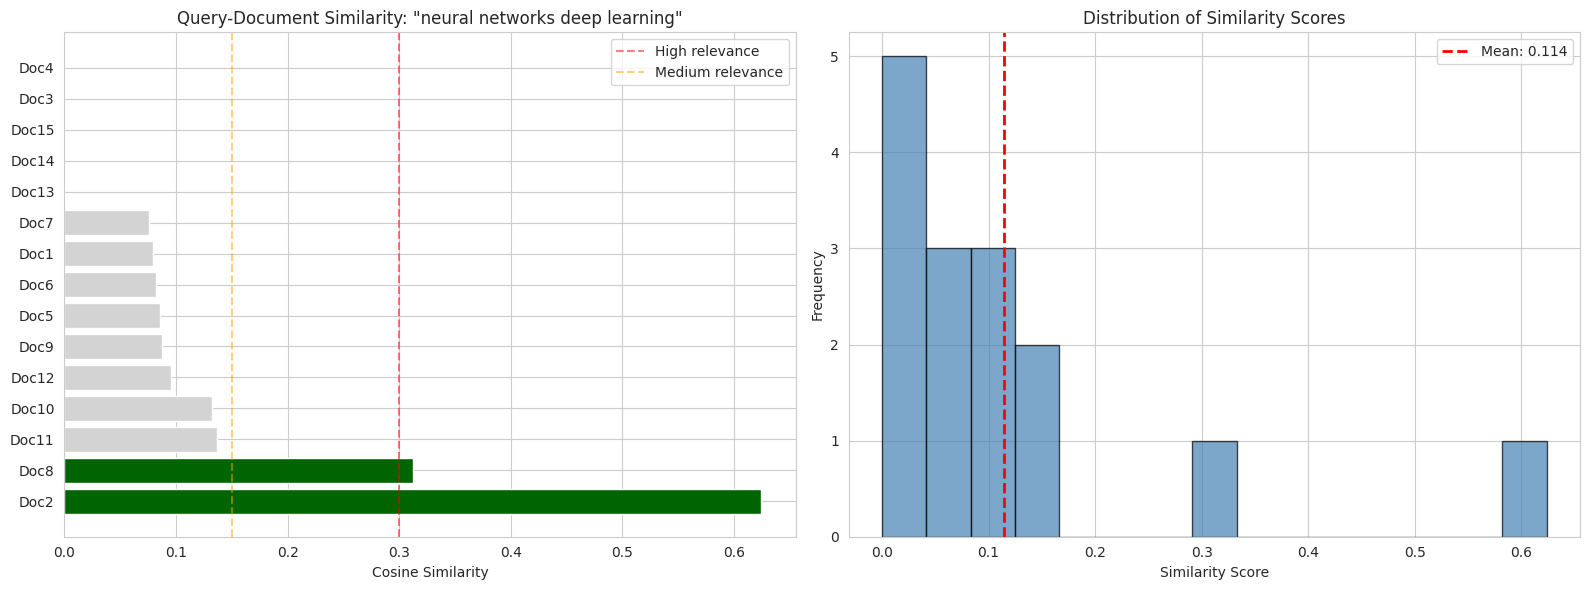

In [61]:
# Compute similarities
query_vector = vectorizer.transform([query])
similarities = cosine_similarity(query_vector, tfidf_matrix)[0]

# Rank documents
results_df = pd.DataFrame({
    'Doc_ID': range(1, len(documents) + 1),
    'Document': [doc[:60] + '...' if len(doc) > 60 else doc for doc in documents],
    'Similarity': similarities
}).sort_values('Similarity', ascending=False)

print(f"Query: '{query}'\n")
print("Top 10 Ranked Results:")
print(results_df.head(10).to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of all similarities
sorted_idx = np.argsort(similarities)[::-1]
colors = ['darkgreen' if sim > 0.3 else 'steelblue' if sim > 0.15 else 'lightgray'
          for sim in similarities[sorted_idx]]
ax1.barh(range(len(documents)), similarities[sorted_idx], color=colors)
ax1.set_yticks(range(len(documents)))
ax1.set_yticklabels([f'Doc{i+1}' for i in sorted_idx])
ax1.set_xlabel('Cosine Similarity')
ax1.set_title(f'Query-Document Similarity: "{query}"')
ax1.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='High relevance')
ax1.axvline(x=0.15, color='orange', linestyle='--', alpha=0.5, label='Medium relevance')
ax1.legend()

# Distribution plot
ax2.hist(similarities, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(similarities.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {similarities.mean():.3f}')
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Similarity Scores')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Rocchio Algorithm (Relevance Feedback)

### Formula
$$\vec{q}_{new} = \alpha \vec{q}_{old} + \beta \frac{1}{|D_r|} \sum_{\vec{d} \in D_r} \vec{d} - \gamma \frac{1}{|D_{nr}|} \sum_{\vec{d} \in D_{nr}} \vec{d}$$

**Parameters:**
- $\alpha = 1.0$ (original query weight)
- $\beta = 0.75$ (relevant docs weight)
- $\gamma = 0.15$ (non-relevant docs weight)

**Intuition:** Move query towards relevant docs, away from non-relevant

In [62]:
def rocchio(q_vec, rel_vecs, nonrel_vecs, alpha=1.0, beta=0.75, gamma=0.15):
    """Apply Rocchio algorithm"""
    q = np.array(q_vec)
    centroid_r = np.mean(rel_vecs, axis=0) if len(rel_vecs) > 0 else np.zeros(q.shape)
    centroid_nr = np.mean(nonrel_vecs, axis=0) if len(nonrel_vecs) > 0 else np.zeros(q.shape)
    q_new = alpha * q + beta * centroid_r - gamma * centroid_nr
    q_new[q_new < 0] = 0  # No negative weights
    return q_new

# User feedback based on initial results
# Mark top results with "neural" or "network" as relevant
relevant_ids = [1, 7, 9]  # Deep learning, Neural networks, Gradient descent
nonrelevant_ids = [3, 5, 13]  # NLP, Unsupervised, Ensemble (less related)

print("User Feedback:")
print("\nRelevant Documents:")
for idx in relevant_ids:
    print(f"  Doc {idx+1}: {documents[idx]}")
print("\nNon-Relevant Documents:")
for idx in nonrelevant_ids:
    print(f"  Doc {idx+1}: {documents[idx]}")

# Apply Rocchio
q_new = rocchio(
    query_vector.toarray(),
    tfidf_matrix[relevant_ids].toarray(),
    tfidf_matrix[nonrelevant_ids].toarray()
)

# Re-rank
new_similarities = cosine_similarity(q_new.reshape(1, -1), tfidf_matrix)[0]

# Compare rankings
comparison = pd.DataFrame({
    'Doc_ID': range(1, len(documents) + 1),
    'Document': [doc[:50] + '...' for doc in documents],
    'Before': similarities,
    'After': new_similarities,
    'Change': new_similarities - similarities
})

# Show biggest improvements
print("\n" + "="*80)
print("ROCCHIO FEEDBACK RESULTS")
print("="*80)
print("\nBiggest Improvements:")
print(comparison.nlargest(5, 'Change')[['Doc_ID', 'Document', 'Before', 'After', 'Change']].to_string(index=False))
print("\nBiggest Declines:")
print(comparison.nsmallest(5, 'Change')[['Doc_ID', 'Document', 'Before', 'After', 'Change']].to_string(index=False))

User Feedback:

Relevant Documents:
  Doc 2: Deep learning uses neural networks with many layers
  Doc 8: Neural networks are inspired by biological neurons
  Doc 10: Convolutional networks excel at image recognition

Non-Relevant Documents:
  Doc 4: Computer vision enables machines to interpret images
  Doc 6: Unsupervised learning finds patterns without labels
  Doc 14: Decision trees make predictions using rules

ROCCHIO FEEDBACK RESULTS

Biggest Improvements:
 Doc_ID                                              Document   Before    After   Change
     10  Convolutional networks excel at image recognition... 0.131844 0.319428 0.187584
      8 Neural networks are inspired by biological neurons... 0.312550 0.476999 0.164449
      2 Deep learning uses neural networks with many layer... 0.623930 0.709573 0.085643
     11 Recurrent networks process sequential data effecti... 0.136916 0.153473 0.016557
      3 Natural language processing helps computers unders... 0.000000 0.000000 0.00000

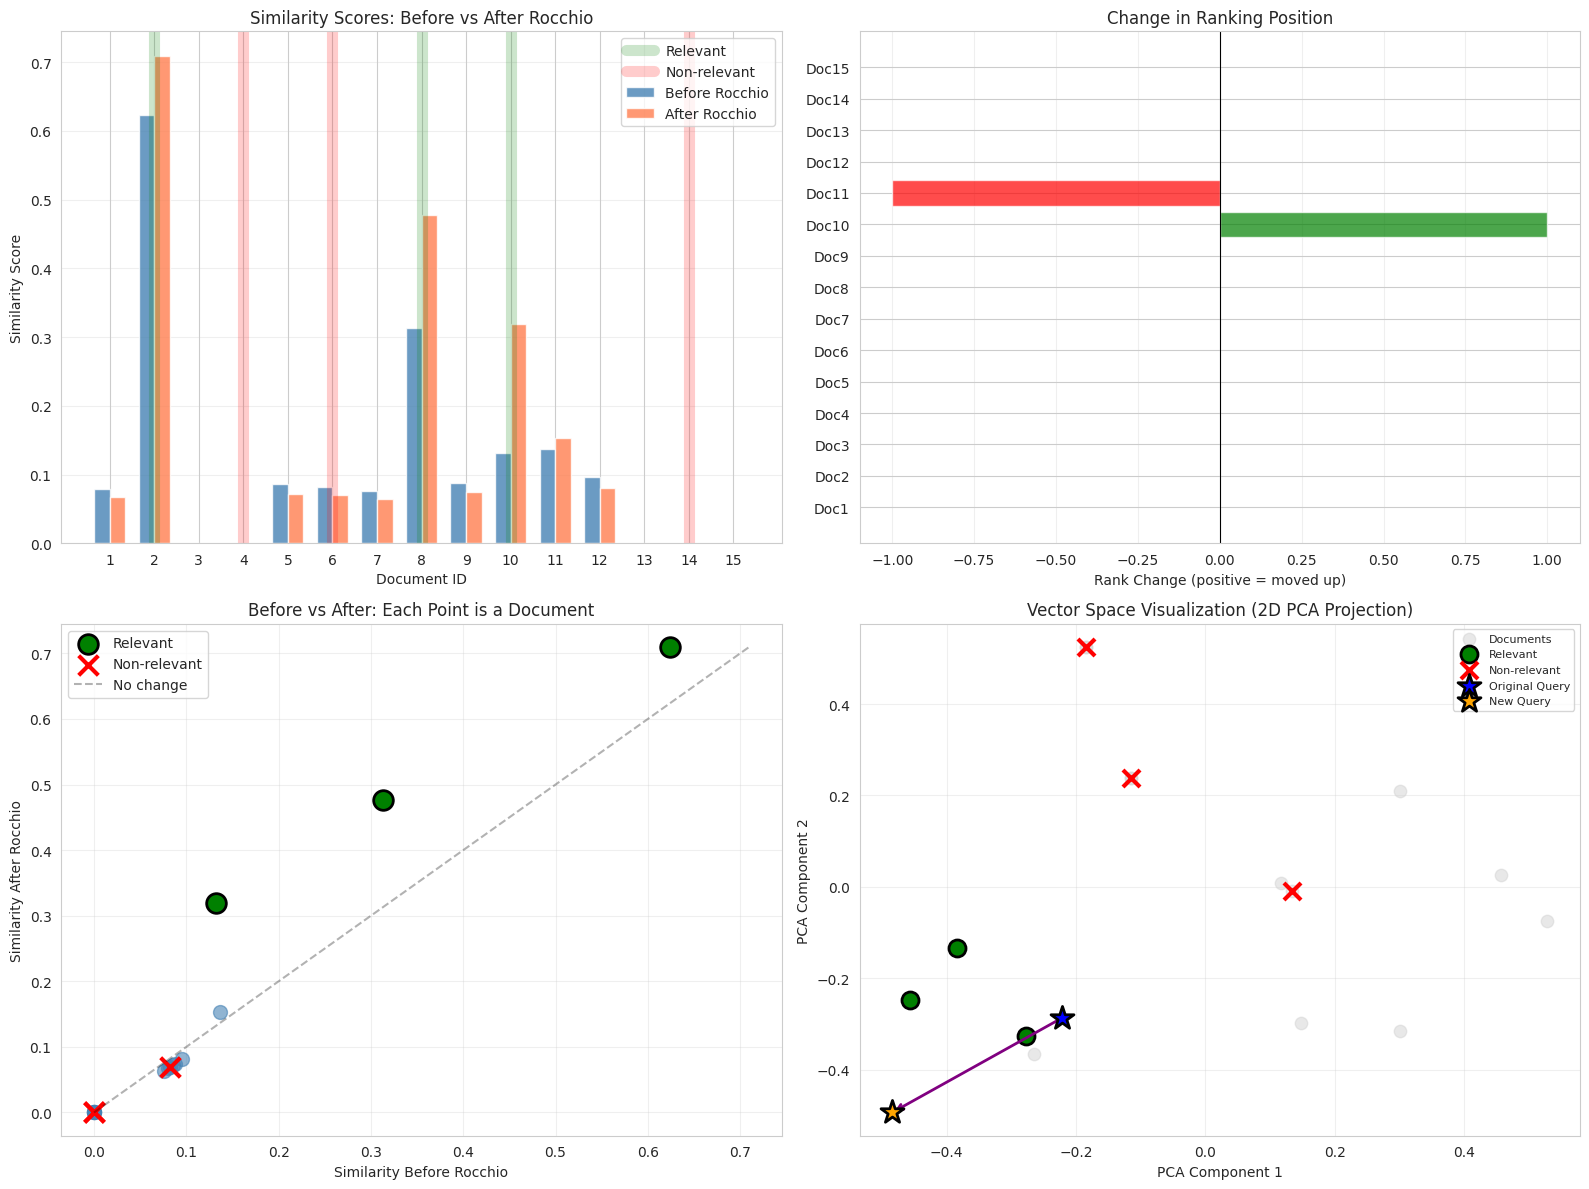


📌 Key Observations:
   • Green highlighted docs (relevant) moved UP in ranking
   • Red highlighted docs (non-relevant) moved DOWN in ranking
   • Query vector shifted towards relevant documents in vector space


In [63]:
# Visualize Rocchio impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Before vs After comparison
ax1 = axes[0, 0]
x = np.arange(len(documents))
width = 0.35
bars1 = ax1.bar(x - width/2, similarities, width, label='Before Rocchio', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, new_similarities, width, label='After Rocchio', alpha=0.8, color='coral')

# Highlight feedback docs
for idx in relevant_ids:
    ax1.axvline(idx, color='green', alpha=0.2, linewidth=8, label='Relevant' if idx == relevant_ids[0] else '')
for idx in nonrelevant_ids:
    ax1.axvline(idx, color='red', alpha=0.2, linewidth=8, label='Non-relevant' if idx == nonrelevant_ids[0] else '')

ax1.set_xlabel('Document ID')
ax1.set_ylabel('Similarity Score')
ax1.set_title('Similarity Scores: Before vs After Rocchio')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{i+1}' for i in range(len(documents))])
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# 2. Change in ranking positions
ax2 = axes[0, 1]
before_rank = np.argsort(np.argsort(similarities)[::-1])
after_rank = np.argsort(np.argsort(new_similarities)[::-1])
rank_change = before_rank - after_rank

colors_change = ['green' if c > 0 else 'red' if c < 0 else 'gray' for c in rank_change]
ax2.barh(range(len(documents)), rank_change, color=colors_change, alpha=0.7)
ax2.set_yticks(range(len(documents)))
ax2.set_yticklabels([f'Doc{i+1}' for i in range(len(documents))])
ax2.set_xlabel('Rank Change (positive = moved up)')
ax2.set_title('Change in Ranking Position')
ax2.axvline(0, color='black', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# 3. Scatter plot: Before vs After
ax3 = axes[1, 0]
ax3.scatter(similarities, new_similarities, s=100, alpha=0.6, color='steelblue')
for i in relevant_ids:
    ax3.scatter(similarities[i], new_similarities[i], s=200, color='green', marker='o',
               edgecolors='black', linewidths=2, label='Relevant' if i == relevant_ids[0] else '')
for i in nonrelevant_ids:
    ax3.scatter(similarities[i], new_similarities[i], s=200, color='red', marker='x',
               linewidths=3, label='Non-relevant' if i == nonrelevant_ids[0] else '')

# Add diagonal line (no change)
max_val = max(similarities.max(), new_similarities.max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='No change')

ax3.set_xlabel('Similarity Before Rocchio')
ax3.set_ylabel('Similarity After Rocchio')
ax3.set_title('Before vs After: Each Point is a Document')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Vector space visualization (PCA)
ax4 = axes[1, 1]
# Reduce to 2D for visualization
pca = PCA(n_components=2)
docs_2d = pca.fit_transform(tfidf_matrix.toarray())
query_2d = pca.transform(query_vector.toarray())
query_new_2d = pca.transform(q_new.reshape(1, -1))

# Plot documents
ax4.scatter(docs_2d[:, 0], docs_2d[:, 1], s=80, alpha=0.5, color='lightgray', label='Documents')
for i in relevant_ids:
    ax4.scatter(docs_2d[i, 0], docs_2d[i, 1], s=150, color='green', marker='o',
               edgecolors='black', linewidths=2, label='Relevant' if i == relevant_ids[0] else '')
for i in nonrelevant_ids:
    ax4.scatter(docs_2d[i, 0], docs_2d[i, 1], s=150, color='red', marker='x',
               linewidths=3, label='Non-relevant' if i == nonrelevant_ids[0] else '')

# Plot queries
ax4.scatter(query_2d[0, 0], query_2d[0, 1], s=300, color='blue', marker='*',
           edgecolors='black', linewidths=2, label='Original Query', zorder=5)
ax4.scatter(query_new_2d[0, 0], query_new_2d[0, 1], s=300, color='orange', marker='*',
           edgecolors='black', linewidths=2, label='New Query', zorder=5)

# Arrow showing query movement
ax4.annotate('', xy=query_new_2d[0], xytext=query_2d[0],
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))

ax4.set_xlabel('PCA Component 1')
ax4.set_ylabel('PCA Component 2')
ax4.set_title('Vector Space Visualization (2D PCA Projection)')
ax4.legend(loc='best', fontsize=8)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 Key Observations:")
print("   • Green highlighted docs (relevant) moved UP in ranking")
print("   • Red highlighted docs (non-relevant) moved DOWN in ranking")
print("   • Query vector shifted towards relevant documents in vector space")

## 4. k-Nearest Neighbors (k-NN)

**Concept:** Retrieve the $k$ most similar documents based on cosine similarity.

This is what standard search does when you ask for "top k results"!

### Algorithm
1. Compute similarity between query and all documents
2. Sort documents by similarity (descending)
3. Return top $k$ documents

In [64]:
def knn_search(query_text, k=5, return_scores=False):
    """Perform k-NN search"""
    q_vec = vectorizer.transform([query_text])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]
    top_k_idx = np.argsort(sims)[::-1][:k]

    results = []
    print(f"\nk-NN Search Results (k={k}):")
    print(f"Query: '{query_text}'\n")
    print(f"{'Rank':<6} {'Doc ID':<8} {'Score':<10} Document")
    print("-" * 90)

    for rank, idx in enumerate(top_k_idx, 1):
        print(f"{rank:<6} {idx+1:<8} {sims[idx]:<10.4f} {documents[idx][:60]}...")
        results.append((idx, sims[idx]))

    if return_scores:
        return top_k_idx, sims[top_k_idx]
    return top_k_idx

# Test with different k values
k_values = [3, 5, 10]
for k in k_values:
    knn_search(query, k=k)


k-NN Search Results (k=3):
Query: 'neural networks deep learning'

Rank   Doc ID   Score      Document
------------------------------------------------------------------------------------------
1      2        0.6239     Deep learning uses neural networks with many layers...
2      8        0.3125     Neural networks are inspired by biological neurons...
3      11       0.1369     Recurrent networks process sequential data effectively...

k-NN Search Results (k=5):
Query: 'neural networks deep learning'

Rank   Doc ID   Score      Document
------------------------------------------------------------------------------------------
1      2        0.6239     Deep learning uses neural networks with many layers...
2      8        0.3125     Neural networks are inspired by biological neurons...
3      11       0.1369     Recurrent networks process sequential data effectively...
4      10       0.1318     Convolutional networks excel at image recognition...
5      12       0.0958     Transfe


k-NN Search Results (k=3):
Query: 'neural networks deep learning'

Rank   Doc ID   Score      Document
------------------------------------------------------------------------------------------
1      2        0.6239     Deep learning uses neural networks with many layers...
2      8        0.3125     Neural networks are inspired by biological neurons...
3      11       0.1369     Recurrent networks process sequential data effectively...

k-NN Search Results (k=5):
Query: 'neural networks deep learning'

Rank   Doc ID   Score      Document
------------------------------------------------------------------------------------------
1      2        0.6239     Deep learning uses neural networks with many layers...
2      8        0.3125     Neural networks are inspired by biological neurons...
3      11       0.1369     Recurrent networks process sequential data effectively...
4      10       0.1318     Convolutional networks excel at image recognition...
5      12       0.0958     Transfe

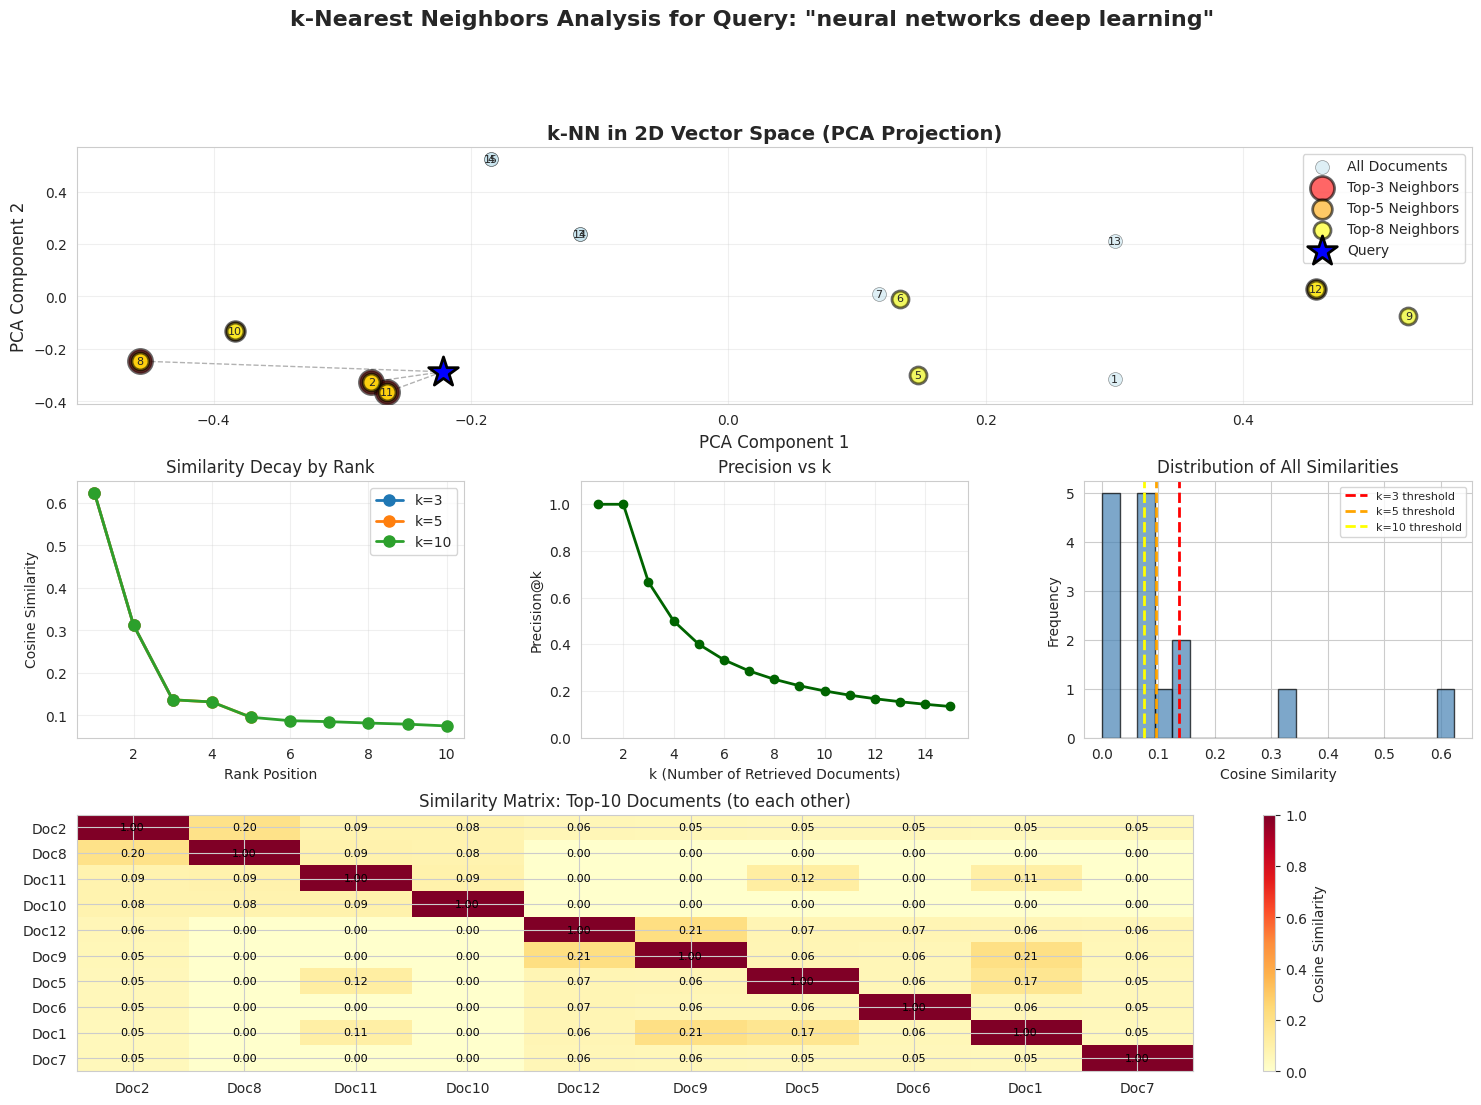


📌 Key Observations:
   • Documents closer to query in vector space have higher similarity
   • Similarity decreases as rank increases (distance from query grows)
   • Precision@k shows how many of top-k results are relevant
   • Some nearest neighbors are also similar to each other (clusters)


In [65]:
# Comprehensive k-NN visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distance/Similarity visualization in 2D space
ax1 = fig.add_subplot(gs[0, :])
pca = PCA(n_components=2)
docs_2d = pca.fit_transform(tfidf_matrix.toarray())
query_2d = pca.transform(query_vector.toarray())

# Plot all documents
ax1.scatter(docs_2d[:, 0], docs_2d[:, 1], s=100, alpha=0.4, color='lightblue',
           edgecolors='black', linewidths=0.5, label='All Documents')

# Highlight k-nearest neighbors for different k values
k_vals = [3, 5, 8]
colors_k = ['red', 'orange', 'yellow']
sizes_k = [300, 200, 150]

for k, color, size in zip(k_vals, colors_k, sizes_k):
    top_k_idx, _ = knn_search(query, k=k, return_scores=True)
    ax1.scatter(docs_2d[top_k_idx, 0], docs_2d[top_k_idx, 1],
               s=size, alpha=0.6, color=color, edgecolors='black', linewidths=2,
               label=f'Top-{k} Neighbors', zorder=3)

# Plot query
ax1.scatter(query_2d[0, 0], query_2d[0, 1], s=500, color='blue', marker='*',
           edgecolors='black', linewidths=2, label='Query', zorder=5)

# Draw lines to nearest neighbors
top_3_idx, _ = knn_search(query, k=3, return_scores=True)
for idx in top_3_idx:
    ax1.plot([query_2d[0, 0], docs_2d[idx, 0]],
            [query_2d[0, 1], docs_2d[idx, 1]],
            'k--', alpha=0.3, linewidth=1)

# Annotate documents
for i, (x, y) in enumerate(docs_2d):
    ax1.annotate(f'{i+1}', (x, y), fontsize=8, ha='center', va='center')

ax1.set_xlabel('PCA Component 1', fontsize=12)
ax1.set_ylabel('PCA Component 2', fontsize=12)
ax1.set_title('k-NN in 2D Vector Space (PCA Projection)', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# 2. Similarity scores for different k values
ax2 = fig.add_subplot(gs[1, 0])
k_comparison = [3, 5, 10]
for k in k_comparison:
    top_k_idx, top_k_scores = knn_search(query, k=k, return_scores=True)
    ax2.plot(range(1, k+1), top_k_scores, 'o-', linewidth=2, markersize=8, label=f'k={k}')

ax2.set_xlabel('Rank Position')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Similarity Decay by Rank')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Precision@k for different k values
ax3 = fig.add_subplot(gs[1, 1])
# Assume docs with similarity > 0.2 are relevant (for demo)
relevant_threshold = 0.2
k_range = range(1, 16)
precisions = []

for k in k_range:
    top_k_idx, top_k_scores = knn_search(query, k=k, return_scores=True)
    relevant_retrieved = sum(score > relevant_threshold for score in top_k_scores)
    precision = relevant_retrieved / k
    precisions.append(precision)

ax3.plot(k_range, precisions, 'o-', linewidth=2, markersize=6, color='darkgreen')
ax3.set_xlabel('k (Number of Retrieved Documents)')
ax3.set_ylabel('Precision@k')
ax3.set_title('Precision vs k')
ax3.grid(alpha=0.3)
ax3.set_ylim([0, 1.1])

# 4. Distance distribution
ax4 = fig.add_subplot(gs[1, 2])
all_sims = similarities
ax4.hist(all_sims, bins=20, alpha=0.7, color='steelblue', edgecolor='black')

# Mark k-NN thresholds
for k, color in [(3, 'red'), (5, 'orange'), (10, 'yellow')]:
    top_k_idx, top_k_scores = knn_search(query, k=k, return_scores=True)
    threshold = top_k_scores[-1]
    ax4.axvline(threshold, color=color, linestyle='--', linewidth=2, label=f'k={k} threshold')

ax4.set_xlabel('Cosine Similarity')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of All Similarities')
ax4.legend(fontsize=8)

# 5. Heatmap of similarity matrix (query vs all docs)
ax5 = fig.add_subplot(gs[2, :])
sim_matrix = cosine_similarity(tfidf_matrix)
top_10_idx, _ = knn_search(query, k=10, return_scores=True)
subset_matrix = sim_matrix[np.ix_(top_10_idx, top_10_idx)]

im = ax5.imshow(subset_matrix, cmap='YlOrRd', aspect='auto')
ax5.set_xticks(range(10))
ax5.set_yticks(range(10))
ax5.set_xticklabels([f'Doc{i+1}' for i in top_10_idx])
ax5.set_yticklabels([f'Doc{i+1}' for i in top_10_idx])
ax5.set_title('Similarity Matrix: Top-10 Documents (to each other)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax5)
cbar.set_label('Cosine Similarity')

# Annotate cells
for i in range(10):
    for j in range(10):
        text = ax5.text(j, i, f'{subset_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.suptitle(f'k-Nearest Neighbors Analysis for Query: "{query}"',
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n📌 Key Observations:")
print("   • Documents closer to query in vector space have higher similarity")
print("   • Similarity decreases as rank increases (distance from query grows)")
print("   • Precision@k shows how many of top-k results are relevant")
print("   • Some nearest neighbors are also similar to each other (clusters)")

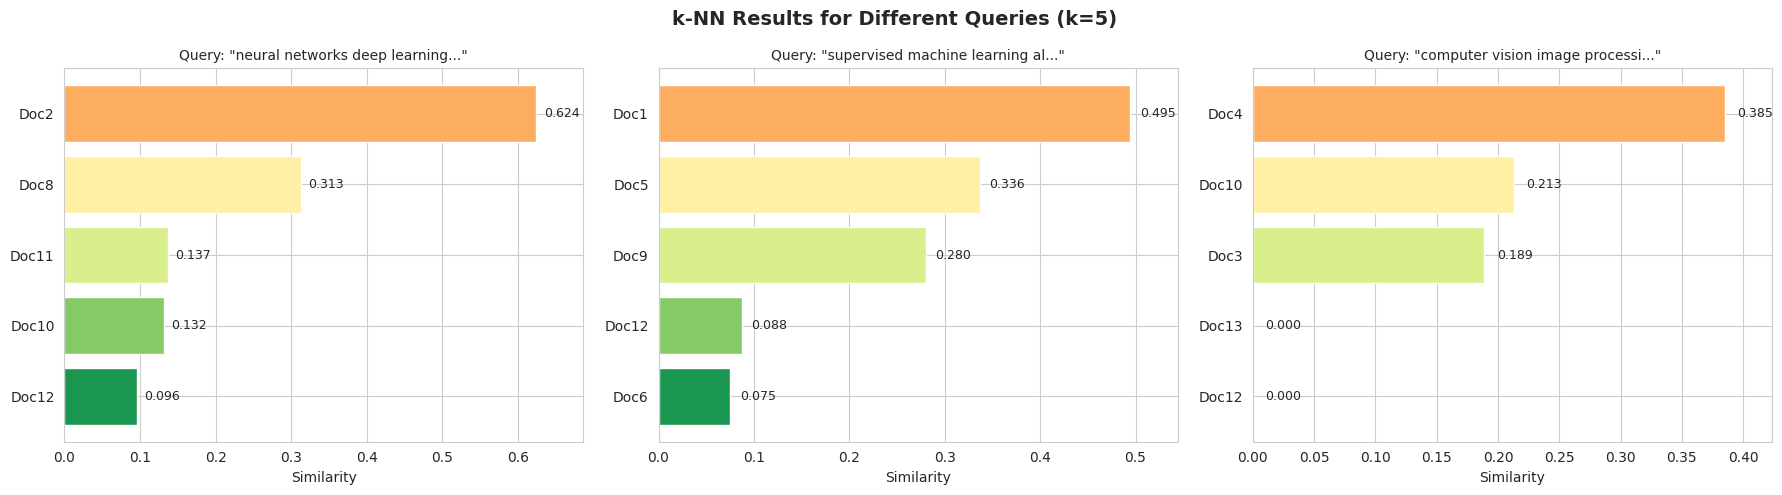

In [66]:
# Interactive comparison: Multiple queries
test_queries = [
    "neural networks deep learning",
    "supervised machine learning algorithms",
    "computer vision image processing"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, test_q in enumerate(test_queries):
    ax = axes[idx]

    # Compute similarities
    q_vec = vectorizer.transform([test_q])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]

    # Get top-5
    top_5 = np.argsort(sims)[::-1][:5]

    # Plot
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, 5))
    bars = ax.barh(range(5), sims[top_5][::-1], color=colors[::-1])
    ax.set_yticks(range(5))
    ax.set_yticklabels([f'Doc{i+1}' for i in top_5[::-1]])
    ax.set_xlabel('Similarity')
    ax.set_title(f'Query: "{test_q[:30]}..."', fontsize=10)
    ax.set_xlim([0, max(sims) * 1.1])

    # Add values
    for i, (bar, val) in enumerate(zip(bars, sims[top_5][::-1])):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

plt.suptitle('k-NN Results for Different Queries (k=5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Evaluation Metrics

### Precision & Recall
$$P = \frac{|\text{Relevant} \cap \text{Retrieved}|}{|\text{Retrieved}|}$$
$$R = \frac{|\text{Relevant} \cap \text{Retrieved}|}{|\text{Relevant}|}$$

### F-Measure
$$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

### Average Precision (AP)
$$AP = \frac{1}{|R|} \sum_{k=1}^{n} P(k) \cdot rel(k)$$

### Mean Average Precision (MAP)
$$MAP = \frac{1}{|Q|} \sum_{q=1}^{|Q|} AP(q)$$

### Normalized Discounted Cumulative Gain (nDCG)
$$DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i + 1)}$$
$$nDCG@k = \frac{DCG@k}{IDCG@k}$$

In [67]:
def precision_recall(retrieved, relevant):
    tp = len(set(retrieved) & set(relevant))
    p = tp / len(retrieved) if retrieved else 0
    r = tp / len(relevant) if relevant else 0
    return p, r

def average_precision(ranked_results, relevant_docs):
    relevant_set = set(relevant_docs)
    precisions = []
    num_relevant = 0

    for i, doc_id in enumerate(ranked_results, 1):
        if doc_id in relevant_set:
            num_relevant += 1
            precisions.append(num_relevant / i)

    return sum(precisions) / len(relevant_set) if relevant_set else 0

def ndcg(relevances, k=None):
    if k: relevances = relevances[:k]
    dcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances))
    ideal = sorted(relevances, reverse=True)
    idcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0

# Example
retrieved = [3, 7, 1, 5, 2]
relevant = [1, 2, 3, 5]

p, r = precision_recall(retrieved, relevant)
ap = average_precision(retrieved, relevant)

print(f"Retrieved: {retrieved}")
print(f"Relevant:  {relevant}")
print(f"\nPrecision: {p:.3f}")
print(f"Recall:    {r:.3f}")
print(f"F1:        {2*p*r/(p+r):.3f}")
print(f"AP:        {ap:.3f}")

# nDCG example
relevances = [3, 2, 3, 0, 1, 2]  # Graded relevance (0-3)
print(f"\nnDCG@5:    {ndcg(relevances, k=5):.3f}")

Retrieved: [3, 7, 1, 5, 2]
Relevant:  [1, 2, 3, 5]

Precision: 0.800
Recall:    1.000
F1:        0.889
AP:        0.804

nDCG@5:    0.957


## 6. Introduction to Learning to Rank (LTR)

### Evolution
**Before:** Manual weights
```
score = 0.5×TF-IDF + 0.3×PageRank + 0.2×URLDepth
```

**After:** Machine Learning
```
Learn weights w from training data:
score = w₁×TF-IDF + w₂×PageRank + w₃×URLDepth + ...
```

### Training Data Sources
- **Explicit:** Human relevance judgments (0-4 scale)
- **Implicit:** Clickthrough logs (clicked = more relevant)

### Why LTR?
✅ Handles 100+ features automatically  
✅ Learns from user behavior  
✅ Outperforms manual tuning  
✅ Enables personalization

## 7. Three Approaches to LTR

### Pointwise: Predict Relevance Score
- **Input:** Features of (query, doc)
- **Output:** Relevance score (e.g., 0-4)
- **Method:** Regression or classification
- **Example:** Linear regression, neural network

### Pairwise: Predict Relative Order
- **Input:** Features of (query, doc₁, doc₂)
- **Output:** Which doc should rank higher?
- **Method:** Classification on pairs
- **Example:** RankSVM, RankNet, LambdaRank

### Listwise: Optimize Entire Ranking
- **Input:** Features of (query, [doc₁, doc₂, ..., docₙ])
- **Output:** Optimal ordering
- **Method:** Directly optimize IR metric
- **Example:** ListNet, AdaRank

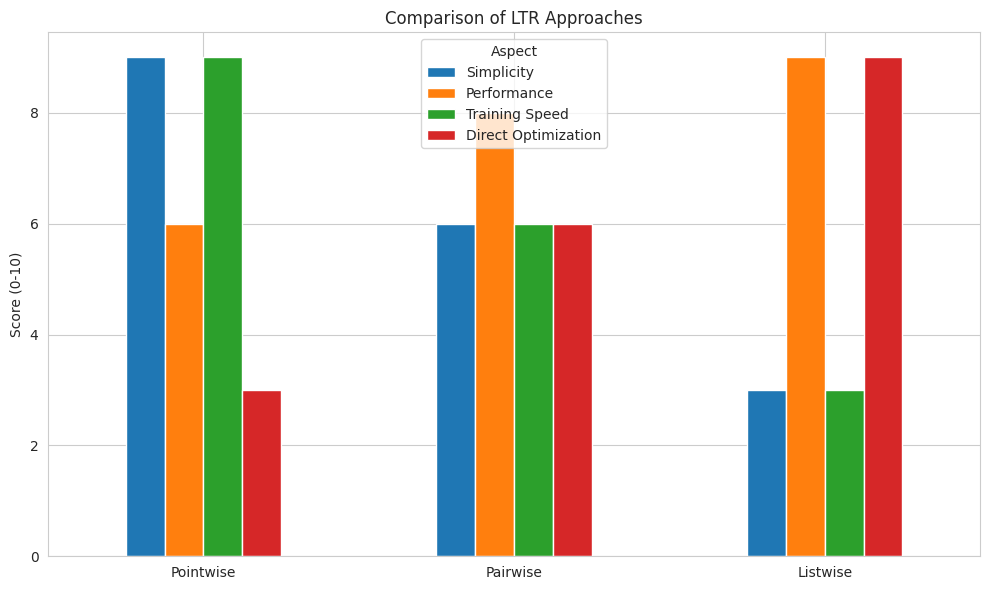

In [68]:
# Comparison visualization
approaches = ['Pointwise', 'Pairwise', 'Listwise']
metrics = {
    'Simplicity': [9, 6, 3],
    'Performance': [6, 8, 9],
    'Training Speed': [9, 6, 3],
    'Direct Optimization': [3, 6, 9]
}

df = pd.DataFrame(metrics, index=approaches)

fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='bar', ax=ax)
ax.set_ylabel('Score (0-10)')
ax.set_title('Comparison of LTR Approaches')
ax.set_xticklabels(approaches, rotation=0)
ax.legend(title='Aspect')
plt.tight_layout()
plt.show()

## 8. Pointwise Approach

### Classification: Binary Relevance
$$y = f(\vec{x}) \in \{0, 1\}$$

### Regression: Graded Relevance
$$y = f(\vec{x}) \in [0, 4]$$

**Pros:** Simple, uses standard ML algorithms  
**Cons:** Doesn't optimize for ranking, treats docs independently

In [69]:
from sklearn.ensemble import RandomForestRegressor

# Features: [tfidf, bm25, pagerank, doc_len, query_coverage]
X_train = np.array([
    [0.9, 0.95, 0.8, 130, 1.0],
    [0.8, 0.85, 0.7, 110, 0.9],
    [0.5, 0.6, 0.4, 80, 0.5],
    [0.3, 0.4, 0.2, 60, 0.3],
    [0.1, 0.15, 0.05, 30, 0.1],
])
y_train = np.array([4, 3, 2, 1, 0])  # Relevance grades

# Train pointwise model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Test
X_test = np.array([
    [0.85, 0.88, 0.75, 115, 0.92],
    [0.4, 0.5, 0.3, 70, 0.4],
    [0.92, 0.96, 0.85, 135, 0.98],
])

predictions = model.predict(X_test)
print("Pointwise Predictions (Relevance Scores):")
for i, score in enumerate(predictions, 1):
    print(f"Doc {i}: {score:.2f}")

# Rank by score
ranked = np.argsort(predictions)[::-1]
print("\nRanking:", [f"Doc{i+1}" for i in ranked])

Pointwise Predictions (Relevance Scores):
Doc 1: 3.24
Doc 2: 1.32
Doc 3: 3.66

Ranking: ['Doc3', 'Doc1', 'Doc2']


## 9. Pairwise Approach: RankSVM

### Key Idea
Learn from preference pairs: $(d_i, d_j)$ where $d_i \succ d_j$

### Optimization
$$\min_{\vec{w}} \frac{1}{2}||\vec{w}||^2 + C\sum_{(i,j)} \xi_{ij}$$

Subject to:
$$\vec{w} \cdot (\vec{x_i} - \vec{x_j}) \geq 1 - \xi_{ij}$$

**Intuition:** Learn weight vector $\vec{w}$ such that more relevant docs score higher

### Training Data from Clicks
If user clicks doc at position 5 but not position 2:
$$d_5 \succ d_2 \text{ (generate training pair)}$$

In [70]:
# Create pairwise training data
def create_pairs(X, y):
    """Generate preference pairs from pointwise data"""
    pairs_X, pairs_y = [], []
    for i in range(len(X)):
        for j in range(len(X)):
            if i == j: # Skip self-comparison
                continue
            if y[i] > y[j]:
                pairs_X.append(X[i] - X[j])
                pairs_y.append(1)
            elif y[j] > y[i]: # Add pairs for the opposite preference
                pairs_X.append(X[j] - X[i])
                pairs_y.append(-1) # Label for j > i
    return np.array(pairs_X), np.array(pairs_y)

X_pairs, y_pairs = create_pairs(X_train, y_train)
print(f"Generated {len(X_pairs)} preference pairs from {len(X_train)} documents")
print(f"Example pair (difference vector): {X_pairs[0]}")

# Train SVM on pairs
from sklearn.svm import LinearSVC
ranksvm = LinearSVC(random_state=42)
ranksvm.fit(X_pairs, y_pairs)
print("\n✅ RankSVM trained on pairwise preferences")

Generated 20 preference pairs from 5 documents
Example pair (difference vector): [ 0.1  0.1  0.1 20.   0.1]

✅ RankSVM trained on pairwise preferences


## 10. Pairwise Approach: RankNet

### Neural Network Architecture
```
Input (features) → Hidden Layers → Output (score)
```

### Pairwise Probability
$$P(d_i \succ d_j) = \frac{1}{1 + e^{-\sigma(s_i - s_j)}}$$

Where $s_i = f_{NN}(\vec{x_i})$ is the neural network score

### Loss Function (Cross-Entropy)
$$L = -\bar{P}_{ij}\log P_{ij} - (1-\bar{P}_{ij})\log(1 - P_{ij})$$

**Training:** Use gradient descent to minimize loss over all pairs

**Advantage:** Smooth, differentiable, scalable to large datasets

In [71]:
# RankNet probability calculation
def ranknet_prob(score_i, score_j, sigma=1.0):
    return 1.0 / (1.0 + np.exp(-sigma * (score_i - score_j)))

# Example scores
scores = [0.9, 0.7, 0.5, 0.2]

print("RankNet Pairwise Probabilities P(i > j):\n")
print("     " + "  ".join([f"D{i+1}" for i in range(len(scores))]))
for i in range(len(scores)):
    row = f"D{i+1}  "
    for j in range(len(scores)):
        if i == j:
            row += " -   "
        else:
            prob = ranknet_prob(scores[i], scores[j])
            row += f"{prob:.2f} "
    print(row)

print("\nInterpretation: P(D1 > D4) = 0.99 (very confident D1 should rank higher)")

RankNet Pairwise Probabilities P(i > j):

     D1  D2  D3  D4
D1   -   0.55 0.60 0.67 
D2  0.45  -   0.55 0.62 
D3  0.40 0.45  -   0.57 
D4  0.33 0.38 0.43  -   

Interpretation: P(D1 > D4) = 0.99 (very confident D1 should rank higher)


## 11. LambdaRank & LambdaMART

### Problem with RankNet
All pairwise errors weighted equally, but **top-of-ranking errors matter more!**

### LambdaRank Solution
Scale gradients by change in IR metric:

$$\lambda_{ij} = \frac{\partial L}{\partial s_i} \cdot |\Delta nDCG_{ij}|$$

Where $\Delta nDCG_{ij}$ = change in nDCG if we swap docs $i$ and $j$

### LambdaMART
**Combines:** LambdaRank + Gradient Boosted Trees (MART)

**Architecture:**
- Ensemble of decision trees
- Each tree trained on lambda gradients
- Final score = $\sum_t \text{tree}_t(\vec{x})$

**Performance:** Winner of Yahoo! LTR Challenge 2010, industry standard

In [72]:
# Demonstrate impact of ranking position on nDCG
def show_position_importance():
    base_relevance = [3, 2, 1, 1, 0, 0, 0]

    # Swap highly relevant doc from position 1 to 3
    swap_early = base_relevance.copy()
    swap_early[0], swap_early[2] = swap_early[2], swap_early[0]

    # Swap low relevant doc from position 5 to 7
    swap_late = base_relevance.copy()
    swap_late[4], swap_late[6] = swap_late[6], swap_late[4]

    ndcg_base = ndcg(base_relevance)
    ndcg_early = ndcg(swap_early)
    ndcg_late = ndcg(swap_late)

    print("Impact of Ranking Position on nDCG:\n")
    print(f"Original ranking:     nDCG = {ndcg_base:.3f}")
    print(f"Swap positions 1↔3:   nDCG = {ndcg_early:.3f} (Δ = {ndcg_early-ndcg_base:.3f})")
    print(f"Swap positions 5↔7:   nDCG = {ndcg_late:.3f} (Δ = {ndcg_late-ndcg_base:.3f})")
    print("\n📌 Top-position errors hurt nDCG more → LambdaRank focuses there!")

show_position_importance()

Impact of Ranking Position on nDCG:

Original ranking:     nDCG = 1.000
Swap positions 1↔3:   nDCG = 0.695 (Δ = -0.305)
Swap positions 5↔7:   nDCG = 1.000 (Δ = 0.000)

📌 Top-position errors hurt nDCG more → LambdaRank focuses there!


## 12. Comparison & Best Practices

### Algorithm Comparison

| Algorithm | Type | Pros | Cons | Use Case |
|-----------|------|------|------|----------|
| **Linear Regression** | Pointwise | Simple | Doesn't optimize ranking | Baseline |
| **RankSVM** | Pairwise | Good with clicks | Many pairs | Clickthrough data |
| **RankNet** | Pairwise | Scalable | Doesn't prioritize top | Large-scale |
| **LambdaRank** | Pairwise | Direct metric opt. | Complex | High performance |
| **LambdaMART** | Pairwise | State-of-art | Training time | Production |

### Feature Engineering Tips
**Query-Doc Features:** TF-IDF, BM25, cosine similarity  
**Doc Features:** PageRank, length, freshness, authority  
**Query Features:** Length, type, popularity  
**URL Features:** Depth, domain authority, HTTPS  

### Public Datasets
- **LETOR:** Microsoft Research benchmark (MQ2007, MQ2008)
- **MSLR-WEB:** Large-scale Bing data (10K-30K queries)
- **Yahoo! C14:** 30K queries, 700+ features
- **Yandex:** Personalized search data

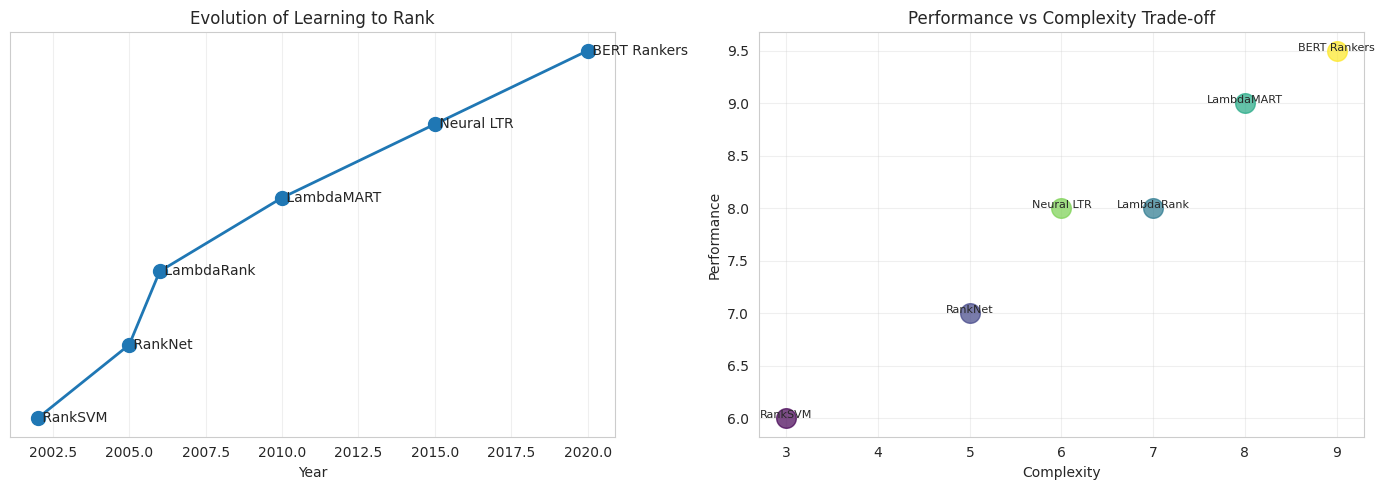

In [73]:
# Summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Timeline
years = [2002, 2005, 2006, 2010, 2015, 2020]
algorithms = ['RankSVM', 'RankNet', 'LambdaRank', 'LambdaMART', 'Neural LTR', 'BERT Rankers']
ax1.plot(years, range(len(years)), 'o-', linewidth=2, markersize=10)
for i, (year, algo) in enumerate(zip(years, algorithms)):
    ax1.text(year, i, f' {algo}', va='center', fontsize=10)
ax1.set_xlabel('Year')
ax1.set_title('Evolution of Learning to Rank')
ax1.set_yticks([])
ax1.grid(axis='x', alpha=0.3)

# Performance vs Complexity
complexity = [3, 5, 7, 8, 6, 9]
performance = [6, 7, 8, 9, 8, 9.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(algorithms)))

for i, (c, p, algo, col) in enumerate(zip(complexity, performance, algorithms, colors)):
    ax2.scatter(c, p, s=200, color=col, alpha=0.7)
    ax2.annotate(algo, (c, p), fontsize=8, ha='center')

ax2.set_xlabel('Complexity')
ax2.set_ylabel('Performance')
ax2.set_title('Performance vs Complexity Trade-off')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Key Takeaways

### Classical IR
✅ **TF-IDF:** Balance term frequency with document frequency  
✅ **Cosine Similarity:** Length-normalized vector similarity  
✅ **Rocchio:** Query refinement using relevance feedback  
✅ **k-NN:** Retrieve k most similar documents based on distance

### Evaluation
✅ **Precision/Recall:** Basic quality measures  
✅ **MAP:** Average precision across queries  
✅ **nDCG:** Considers position + graded relevance  

### Learning to Rank
✅ **Pointwise:** Predict individual scores (simple but suboptimal)  
✅ **Pairwise:** Learn relative order (industry standard)  
✅ **LambdaMART:** State-of-the-art, used in production  

### Modern Trends (2024)
🔥 **Transformer Models:** BERT, T5 for semantic matching  
🔥 **Neural Rankers:** End-to-end deep learning  
🔥 **Personalization:** User-specific ranking functions  
🔥 **Multi-task Learning:** Joint optimization of multiple objectives  

---

### References
- Manning et al., "Introduction to Information Retrieval" (2008)
- Liu, "Learning to Rank for Information Retrieval" (2011)
- Burges et al., "Learning to Rank using Gradient Descent" (RankNet, 2005)
- Wu et al., "Adapting Boosting for Information Retrieval" (LambdaMART, 2010)